In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize
import random

In [2]:
T = pd.read_csv('/Users/siyangwei/Documents/ANES_datasets/anes_timeseries_cdf_csv_20220916/anes_timeseries_cdf_csv_20220916.csv',
                low_memory=False)
T['VCF0101'] = pd.to_numeric(T['VCF0101'],errors='coerce',downcast='integer')
T = T[T['VCF0101']<=80]   # restrict age <= 80
T['VCF0004'] = pd.to_numeric(T['VCF0004'],errors='coerce',downcast='integer')
year = T['VCF0004']       
yr = set(year)      # extract survey years
age = T['VCF0101']       # extract respondent age
M = pd.concat([year,age],axis=1,join='inner')

In [3]:
# import real US matrix
Wim = pd.read_excel('/Users/siyangwei/Documents/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx',
                   sheet_name = 53, header = None)
Wim = Wim.to_numpy()

/Users/siyangwei/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# preprocess interaction matrix
N = 16
WUS = np.copy(Wim)
# the real US matrix (scale entries by maximum row sum)
#rowsumax = max(np.sum(Wim, axis=1))
#WUS = WUS/rowsumax

# constant matrix W
Wc = np.ones([N,N])

# symmetrized US matrix
# scale WUS such that the first row and col both sums to 1
Wnml = np.copy(WUS)
#sc = sum(WUS[1:N,0])/(1-Wnml[0,0])
#Wnml[1:N,0] = WUS[1:N,0]/sc
Wsym = (Wnml + np.transpose(Wnml))/2

In [5]:
# matrix used for fit
W = np.copy(Wsym)

In [6]:
# Analyze a question
question = '9005 Supreme Court'
varname = 'VCF' + question[:4]           
csopt = [0.0022,  0.00219]
casopt =  [ 0.02229,  0.01668, -0.01005,  0.00605]


In [7]:
var = T[varname].replace(' ','-1').astype('int')
D = M.join(var,how='inner')

# 1970 type of this question, 0009: 0, 0010: 1, 0011: 2
weightvar = 'VCF0009z'
weight = T[weightvar]
Dw = D.join(weight, how = 'inner')

I = np.zeros([len(yr),7,13])  # 3d array, year, type and type percentage, 13 age groups
J = np.zeros([len(yr),7])  # 2d array, year, type and type percentage
yr = list(yr)
J[:,0] = yr

for j in range(13): # 13 age groups
    
    # extract data for age group j
    maskj = (age > 5*(j+3)) & (age <= 5*(j+4))
    Mag = Dw[maskj == True]
    
    # count for each year
    I[:,0,j] = yr
    for i in range(len(yr)):
        maskyr = (Mag['VCF0004'] == yr[i])
        Magyr = Mag[maskyr == True]
        # number of negative attitude in year i, age group j
        I[i,1,j] = Magyr.loc[(Magyr[varname] >= 0) & (Magyr[varname] < 50), weightvar].sum()
        # neutral
        I[i,2,j] = Magyr.loc[Magyr[varname] == 50, weightvar].sum()
        # positive
        I[i,3,j] = Magyr.loc[(Magyr[varname] > 50) & (Magyr[varname] < 98), weightvar].sum()
        # number of opinion 1 in year i, all age groups
        J[i,1] += I[i,1,j]
        J[i,2] += I[i,2,j]
        J[i,3] += I[i,3,j]

# delete the year without data for I and J
J2 = J[:,[1,2,3]]
J = J[~np.all(J2 == 0, axis = 1)]
t = J[:,0]
In = np.zeros([len(t),7,13])
for k in range(13):
    ind = np.isin(I[:,0,k],t)
    In[:,:,k] = I[ind,:,k]

np.seterr(invalid='ignore') # ignore 0/0 error, will return NaN
# compute opinion 1/ population of each year
In[:,4,:] = In[:,1,:]/np.sum(In[:,[1,2,3],:],1)
In[:,5,:] = In[:,2,:]/np.sum(In[:,[1,2,3],:],1)
In[:,6,:] = In[:,3,:]/np.sum(In[:,[1,2,3],:],1)

J[:,4] = J[:,1]/np.sum(J[:,[1,2,3]],1)
J[:,5] = J[:,2]/np.sum(J[:,[1,2,3]],1)
J[:,6] = J[:,3]/np.sum(J[:,[1,2,3]],1)

In [8]:
# Initial Conditions

tmax = int((t[-1]-t[0]+5)//5 + 1) # ceil division, time gap = age group diff = 5 years
taxis = np.arange(0,tmax)*5 + t[0]
# use the same initial condition as in dataset
pneg = np.zeros([N,tmax])
pneu = np.zeros([N,tmax])
ppos = np.zeros([N,tmax])

# deal with NaN values: replace NaN with average
# intead of replacing with average, replace NaN with the next available value in this year
for i in range(3,N):
    if In[0,4,i-3] != In[0,4,i-3]:
        pneg[i,0] = next((x for x in In[0,4,:] if x == x))
        pneu[i,0] = next((x for x in In[0,5,:] if x == x))
        ppos[i,0] = next((x for x in In[0,6,:] if x == x))
    else:
        pneg[i,0] = In[0,4,i-3]
        pneu[i,0] = In[0,5,i-3]
        ppos[i,0] = In[0,6,i-3]
        
pneg[0:3,0] = In[0,4,2:5] # IC for age 0-15: assume the same as IC for age 25-40
pneu[0:3,0] = In[0,5,2:5]
ppos[0:3,0] = In[0,6,2:5]

In [9]:
# simulation given be and ga
def sim(bet,gam):
    
    p1 = np.zeros([N,tmax])
    p2 = np.zeros([N,tmax])
    p3 = np.zeros([N,tmax])
    p1[:,0] = pneg[:,0]
    p2[:,0] = pneu[:,0]
    p3[:,0] = ppos[:,0]
    for iter in range(tmax-1):
        # the first age group
        p1[0,iter+1] = np.dot(W[0,:],p1[:,iter])/sum(W[0,:])     # negative
        p2[0,iter+1] = np.dot(W[0,:],p2[:,iter])/sum(W[0,:])     # neutral
        p3[0,iter+1] = np.dot(W[0,:],p3[:,iter])/sum(W[0,:])     # positive
        for gp in range(1,N):
                
            p1[gp,iter+1] = np.dot(p1[gp-1,iter],(1-bet[iter]*np.dot(W[gp,:],(1-p1[:,iter])))) + np.dot(p2[gp-1,iter],gam[iter]*np.dot(W[gp,:],p1[:,iter]))
            p2[gp,iter+1] = np.dot(p2[gp-1,iter],(1-bet[iter]*np.dot(W[gp,:],p3[:,iter])-gam[iter]*np.dot(W[gp,:],p1[:,iter]))) + p1[gp-1,iter]*bet[iter]*np.dot(W[gp,:],(1-p1[:,iter])) + p3[gp-1,iter]*gam[iter]*np.dot(W[gp,:],(1-p3[:,iter]))
            p3[gp,iter+1] = p3[gp-1,iter]*(1-gam[iter]*np.dot(W[gp,:],1-p3[:,iter])) + p2[gp-1,iter]*bet[iter]*np.dot(W[gp,:],p3[:,iter])
            
            # sanity check
            
    return p1,p2,p3

In [10]:
# simulations given asymmetric parameters: 
# bel(-1 to 0),ber(0 to 1),gal(0 to -1),gar(1 to 0)
def simasym(beL,beR,gaL,gaR):
    p1 = np.zeros([N,tmax])
    p2 = np.zeros([N,tmax])
    p3 = np.zeros([N,tmax])
    p1[:,0] = pneg[:,0]
    p2[:,0] = pneu[:,0]
    p3[:,0] = ppos[:,0]
    for iter in range(tmax-1):
        # the first age group
        p1[0,iter+1] = np.dot(W[0,:],p1[:,iter])/sum(W[0,:])
        p2[0,iter+1] = np.dot(W[0,:],p2[:,iter])/sum(W[0,:])
        p3[0,iter+1] = np.dot(W[0,:],p3[:,iter])/sum(W[0,:])
        for gp in range(1,N):
            p1[gp,iter+1] = p1[gp-1,iter]*(1-beL[iter]*np.dot(W[gp,:],(1-p1[:,iter]))) + p2[gp-1,iter]*gaL[iter]*np.dot(W[gp,:],p1[:,iter])
            p2[gp,iter+1] = p2[gp-1,iter]*(1-beR[iter]*np.dot(W[gp,:],p3[:,iter])-gaL[iter]*np.dot(W[gp,:],p1[:,iter])) + p1[gp-1,iter]*beL[iter]*np.dot(W[gp,:],(1-p1[:,iter])) + p3[gp-1,iter]*gaR[iter]*np.dot(W[gp,:],(1-p3[:,iter]))
            p3[gp,iter+1] = p3[gp-1,iter]*(1-gaR[iter]*np.dot(W[gp,:],1-p3[:,iter])) + p2[gp-1,iter]*beR[iter]*np.dot(W[gp,:],p3[:,iter])
        
            
    return p1,p2,p3

In [11]:
# sum squared error for constant, symmetric model, parameters c,a(numbers)
def Jcs(param):  
    c = param[0]
    a = param[1]
    sse = 0
    be = (c+a)*np.ones(tmax-1)
    ga = (c-a)*np.ones(tmax-1)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [12]:
# sse for constant, asymmetric model
# parameters cl,cr,al,ar
def Jcas(param):
    sse = 0
    cl = param[0]
    cr = param[1]
    al = param[2]
    ar = param[3]
    bel = (cl+al)*np.ones(tmax-1)
    gal = (cl-al)*np.ones(tmax-1)
    ber = (cr+ar)*np.ones(tmax-1)
    gar = (cr-ar)*np.ones(tmax-1)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [13]:
# linear, symmetric, coordinated
# 3 parameters c, a, g
def Jlsc(param):
    sse = 0
    c = param[0]
    a = param[1]
    g = param[2]
    be = (c+a)*np.ones(tmax-1) + g*np.arange(0,tmax-1)
    ga = (c-a)*np.ones(tmax-1) - g*np.arange(0,tmax-1)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [14]:
# linear, symmetric, uncoordinated
# 4 parameters: c1, g1, c2, g2
def Jlsu(param):
    sse = 0
    c1 = param[0]
    g1 = param[2]
    c2 = param[1]
    g2 = param[3]
    be = c1*np.ones(tmax-1) + g1*np.arange(0,tmax-1)
    ga = c2*np.ones(tmax-1) + g2*np.arange(0,tmax-1)
    pneg,pneu,ppos = sim(be,ga)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [15]:
# sse for linear, asymmetric, coordinated model
# parameters cl,al,gl,cr,ar,gr
def Jlac(param):
    sse = 0
    cl = param[0]
    al = param[1]
    gl = param[2]
    cr = param[3]
    ar = param[4]
    gr = param[5]
    bel = (cl+al)*np.ones(tmax-1) + gl * np.arange(0,tmax-1)
    gal = (cl-al)*np.ones(tmax-1) - gl * np.arange(0,tmax-1)
    ber = (cr+ar)*np.ones(tmax-1) + gr * np.arange(0,tmax-1)
    gar = (cr-ar)*np.ones(tmax-1) - gr * np.arange(0,tmax-1)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [16]:
# sse for linear, asymmetric, uncoordinated model
# 8 parameters c1,c2,c3,c4,g1,g2,g3,g4
def Jlau(param):
    sse = 0
    c1, c2, c3, c4 = param[0], param[1], param[2], param[3]
    g1, g2, g3, g4 = param[4], param[5], param[6], param[7]
    bel = c1*np.ones(tmax-1) + g1 * np.arange(0,tmax-1)
    gal = c2*np.ones(tmax-1) + g2 * np.arange(0,tmax-1)
    ber = c3*np.ones(tmax-1) + g3 * np.arange(0,tmax-1)
    gar = c4*np.ones(tmax-1) + g4 * np.arange(0,tmax-1)
    pneg,pneu,ppos = simasym(bel,ber,gal,gar)
    for k in range(13):
        kindex = ~np.isnan(In[:,4,k])
        pinterpneg = np.interp(t[kindex], taxis, pneg[k+3,:])
        pinterppos = np.interp(t[kindex], taxis, ppos[k+3,:])
        sse += np.sum(np.square(pinterpneg - In[kindex,4,k])) + np.sum(np.square(pinterppos - In[kindex,6,k]))
    return sse

In [17]:
# backtracking line search
def BTLS(fun, w, dw, c = 0.01, gam = 0.5):
    fw = fun(w)
    dwnorm = np.linalg.norm(dw)
    d = -dw * 1e-5 / dwnorm     # descent direction
    deltaf = -c * 1e-5 * dwnorm
    newf = fun(w + d)
    t = 1
    while newf > fw + t * deltaf:
        t = gam * t
        newf = fun(w + t * d)
    return t, d

In [18]:
def grad_descent(fun,w_init,model,eps=1e-6, maxIter=100):
    w = w_init
    dw = np.ones(w_init.shape)
    W = []
    costs = []
    n_iter = 0
    
    while n_iter < maxIter:
        # gradient of fun w.r.t. w
        dw = optimize.approx_fprime(w,fun,epsilon=1.4901161193847656e-08)
        if np.linalg.norm(dw) < 1e-4:
            break
        
        # adaptively choose step size
        lr, d = BTLS(fun, w, dw)
        w = w + lr * d
        
        cost = fun(w)
        
        # sanity check:
        if model == 'cs':
            be = (w[0]+w[1])*np.ones(tmax-1)
            ga = (w[0]-w[1])*np.ones(tmax-1)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
        
        if model == 'cas':
            bel = (w[0]+w[2])*np.ones(tmax-1)
            gal = (w[0]-w[2])*np.ones(tmax-1)
            ber = (w[1]+w[3])*np.ones(tmax-1)
            gar = (w[1]-w[3])*np.ones(tmax-1)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsc':   # linear, symmetric, coordinated
            be = (w[0]+w[1])*np.ones(tmax-1) + w[2]*np.arange(0,tmax-1)
            ga = (w[0]-w[1])*np.ones(tmax-1) - w[2]*np.arange(0,tmax-1)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lsu':     #linear, symmetric, uncoordinated
            be = w[0]*np.ones(tmax-1) + w[2] * np.arange(0,tmax-1)
            ga = w[1]*np.ones(tmax-1) + w[3] * np.arange(0,tmax-1)
            if max(be)>1 or min(be)<0 or max(ga)>1 or min(ga)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lac':      # linear, asymmetric, coordinated
            bel = (w[0]+w[1])*np.ones(tmax-1) + w[2]*np.arange(0,tmax-1)
            gal = (w[0]-w[1])*np.ones(tmax-1) - w[2]*np.arange(0,tmax-1)
            ber = (w[3]+w[4])*np.ones(tmax-1) + w[5]*np.arange(0,tmax-1)
            gar = (w[3]-w[4])*np.ones(tmax-1) - w[5]*np.arange(0,tmax-1)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
        if model == 'lau':
            bel = w[0]*np.ones(tmax-1) + w[4]*np.arange(0,tmax-1)
            gal = w[1]*np.ones(tmax-1) + w[5]*np.arange(0,tmax-1)
            ber = w[2]*np.ones(tmax-1) + w[6]*np.arange(0,tmax-1)
            gar = w[3]*np.ones(tmax-1) + w[7]*np.arange(0,tmax-1)
            if max(bel)>1 or min(bel)<0 or max(gal)>1 or min(gal)<0 or max(ber)>1 or min(ber)<0 or max(gar)>1 or min(gar)<0:
                break
            else:
                W.append(w.copy())
                costs.append(cost)
                n_iter += 1
                
#         if n_iter >= maxIter:
#             break
        
    return W, costs

In [19]:
# import best parameters for constant model
# Read the CSV file into a DataFrame object
#df = pd.read_csv('/Users/siyangwei/Documents/Python/OpinionDynamics/TherWeightedCoeff.csv')
#df1 = df['CS']
#ind = df.index[df['Question'] == question].tolist()[0]
#coeff1 = df1[df1.index % 3 == 2]
#costr1 = coeff1[ind + 2].split(']')[0].split('[')[1:][0].split()
#csopt = [0, 0]
#csopt[0], csopt[1] = float(costr1[0]), float(costr1[1])
#csopt = [0.00467, 0.0026 ]
ssecs = Jcs(csopt)
#df2 = df['CAS']
#coeff2 = df2[df2.index % 3 == 2]
#costr2 = coeff2[ind + 2].split(']')[0].split('[')[1:][0].split()
#casopt = [0,0,0,0]
#casopt = [0.00427, 0.00468, 0.0017,  0.00269]
#casopt[0],casopt[1],casopt[2],casopt[3] = float(costr2[0]),float(costr2[1]),float(costr2[2]),float(costr2[3])
ssecas = Jcas(casopt)

In [20]:
# linear, symmetric, coordinated
i = 0
nt = 500
paramrec = np.zeros((3,nt))
costrec = np.zeros(nt)
while i < nt or min(costrec) > ssecs:
    if i == 0:
        init = np.zeros(3)
        init[0], init[1] = csopt[0], csopt[1]
    else:
        init = np.zeros(3)
        init[0] = random.uniform(0,0.1)
        init[1] = random.uniform(-0.1,0.1)
        init[2] = random.uniform(-0.001,0.001)
    beinit = (init[0]+init[1])*np.ones(tmax-1) + init[2]*np.arange(0,tmax-1)
    gainit = (init[0]-init[1])*np.ones(tmax-1) - init[2]*np.arange(0,tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlsc(init)
        else:
            paramrec = np.append(paramrec, init.reshape(3,1), axis = 1)
            costrec = np.append(costrec, Jlsc(init))
        params, costs = grad_descent(Jlsc,init,'lsc')
        if len(params) == 0:
            if i == 0:
                i += 1
            continue
        lscopt = params[-1]
        be = (lscopt[0]+lscopt[1])*np.ones(tmax-1) + lscopt[2]*np.arange(0,tmax-1)
        ga = (lscopt[0]-lscopt[1])*np.ones(tmax-1) - lscopt[2]*np.arange(0,tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                    safe = False
                    break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(3,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1
    elif i == 0:
        paramrec[:, 0] = init
        costrec[0] = ssecs
        i += 1

sselsc = min(costrec)
besti = np.argmin(costrec)
lscopt = paramrec[:,besti]
print('minimum SSE:',round(sselsc,5))
print('parameters:',np.around(lscopt,decimals=5))

0 2.7611123547313716
100 2.4102826275337788
200 2.4102826275337788
300 2.390593431343661
400 2.390593431343661
minimum SSE: 2.39059
parameters: [ 0.00855  0.00652 -0.00163]


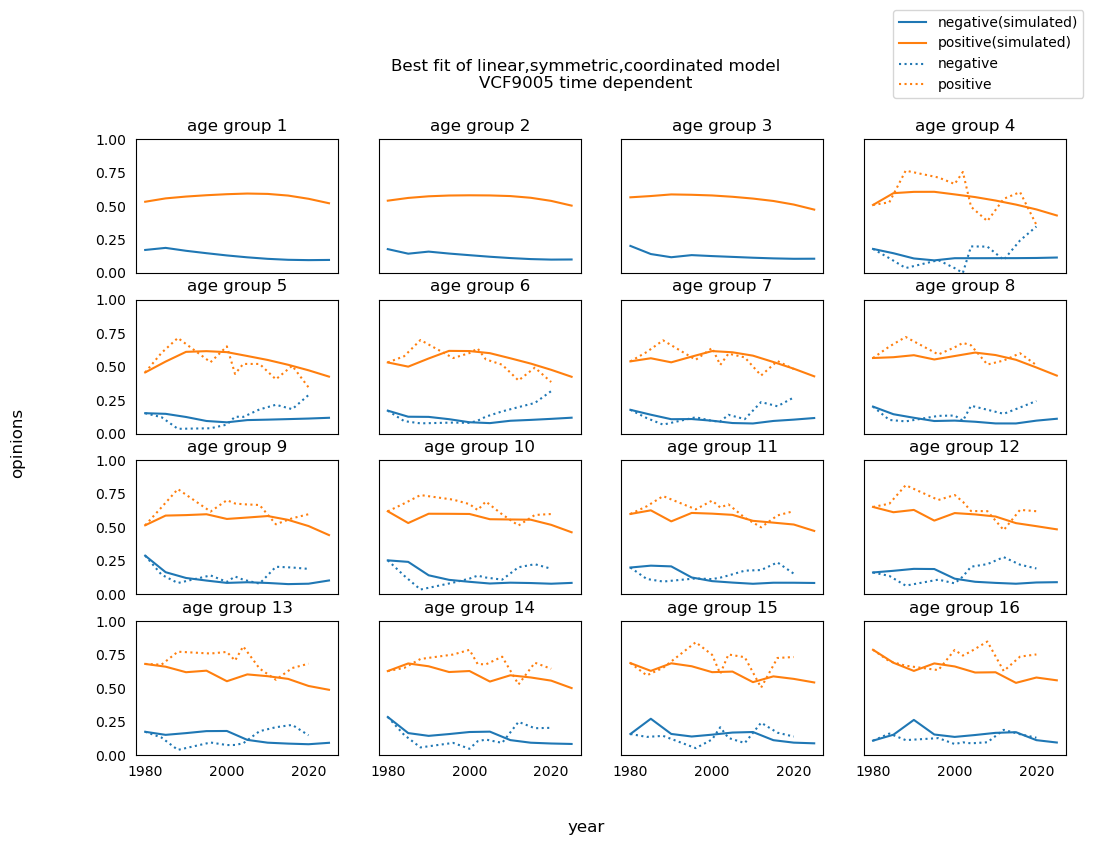

In [21]:
# Visualization
# find the optimal c and a, plot the comparison
be = (lscopt[0]+lscopt[1])*np.ones(tmax-1) + lscopt[2]*np.arange(0,tmax-1)
ga = (lscopt[0]-lscopt[1])*np.ones(tmax-1) - lscopt[2]*np.arange(0,tmax-1)
for k in range(tmax-1):
    for j in range(1, N):
        if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
            print('Warning')
pneg,pneu,ppos = sim(be,ga)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,symmetric,coordinated model\n' + varname + ' time dependent')
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('therweightedtimefits/lsc'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [22]:
## randomly choose ten initial guess
i = 0
nt = 500
paramrec = np.zeros((4,nt))
costrec = np.zeros(nt)
while i < nt or min(costrec) > sselsc:
    init = np.zeros(4)
    if i == 0:
        init[0] = lscopt[0] + lscopt[1]
        init[1] = lscopt[0] - lscopt[1]
        init[2], init[3] = lscopt[2], -lscopt[2]
    else:
        init[0], init[1] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[2], init[3] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    beinit = init[0]*np.ones(tmax-1) + init[2]*np.arange(0,tmax-1)
    gainit = init[1]*np.ones(tmax-1) + init[3]*np.arange(0,tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if beinit[k]*sum(W[j,:])>1 or gainit[k]*sum(W[j,:])>1:
                safe = False
                break
    if safe and min(beinit) > 0 and max(beinit) < 1 and min(gainit) > 0 and max(gainit) < 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlsu(init)
        else:
            paramrec = np.append(paramrec, init.reshape(4,1), axis = 1)
            costrec = np.append(costrec, Jlsu(init))
        params, costs = grad_descent(Jlsu,init,'lsu')
        if len(params) == 0:
            if i == 0:
                i += 1
            continue
        lsuopt = params[-1]
        be = lsuopt[0]*np.ones(tmax-1) + lsuopt[2]*np.arange(0,tmax-1)
        ga = lsuopt[1]*np.ones(tmax-1) + lsuopt[3]*np.arange(0,tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
                    safe = False
                    break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(4,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0:
            i += 1
    elif i == 0:
        paramrec[:,0] = init
        costrec[0] = sselsc
        i += 1

sselsu = min(costrec)
besti = np.argmin(costrec)
lsuopt = paramrec[:,besti]
print('minimum SSE:',round(sselsu,5))
print('parameters:',np.around(lsuopt,decimals=5))

0 2.3291478990501027
100 2.3291478990501027
200 2.3291478990501027
300 2.3291478990501027
400 2.3291478990501027
minimum SSE: 2.32915
parameters: [ 0.01509  0.00185 -0.00188  0.00148]


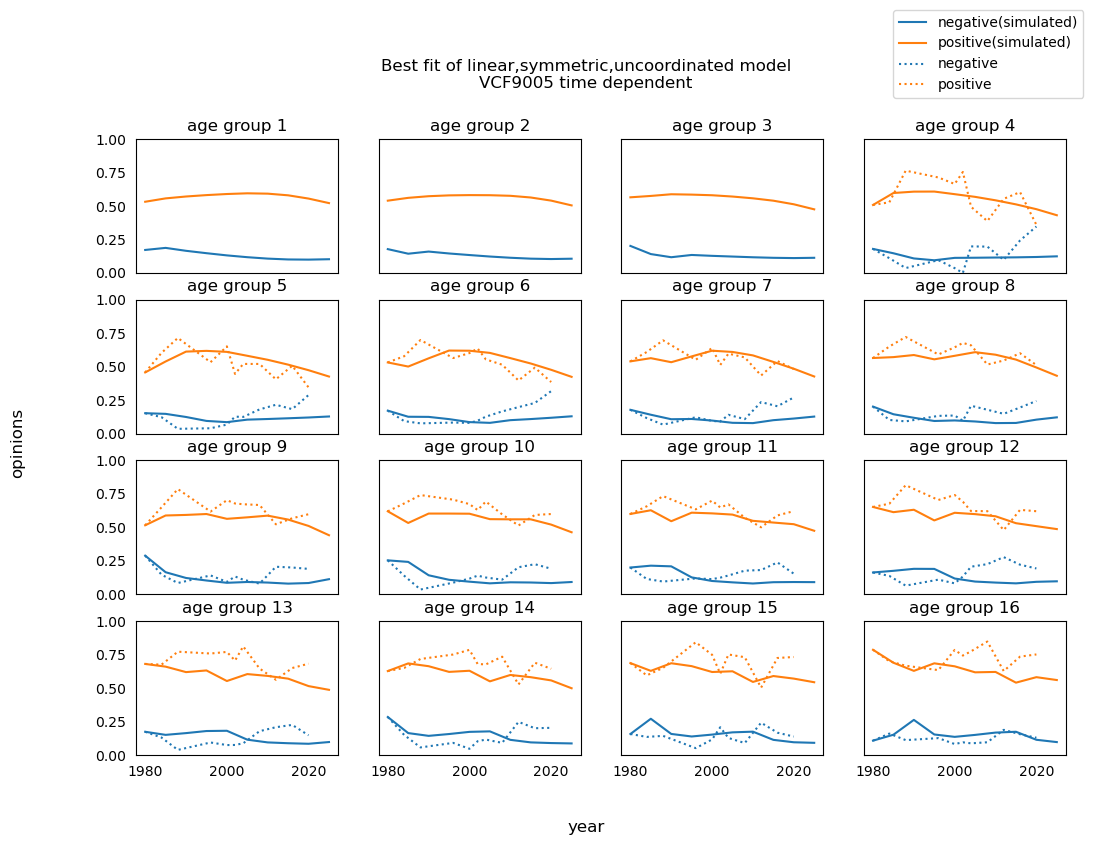

In [23]:
# Visualization
# find the optimal c and a, plot the comparison
be = lsuopt[0]*np.ones(tmax-1) + lsuopt[2]*np.arange(0,tmax-1)
ga = lsuopt[1]*np.ones(tmax-1) + lsuopt[3]*np.arange(0,tmax-1)
for k in range(tmax-1):
    for j in range(1, N):
        if be[k]*sum(W[j,:]) > 1 or ga[k]*sum(W[j, :])>1:
            print('Warning')
pneg,pneu,ppos = sim(be,ga)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,symmetric,uncoordinated model\n' + varname + ' time dependent')
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('therweightedtimefits/'+'lsu'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [24]:
# randomly choose ten initial guess
i = 0
nt = 500
paramrec = np.zeros((6,nt))
costrec = np.zeros(nt)
costrec[0] = float('inf')
while i < nt or min(costrec) > sselsc or min(costrec) > ssecas:
    init = np.zeros(6)
    if i == 0:
        init[0], init[1], init[2] = casopt[0], casopt[2], 0
        init[3], init[4], init[5] = casopt[1], casopt[3], 0
    elif i == 1:
        init[0], init[1], init[2] = lscopt[0], lscopt[1], lscopt[2]
        init[3], init[4], init[5] = lscopt[0], lscopt[1], lscopt[2]
    else:
        init[0], init[3] = random.uniform(0,0.1), random.uniform(0,0.1)
        init[1], init[4] = random.uniform(-0.1,0.1), random.uniform(-0.1,0.1)
        init[2], init[5] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    belinit = (init[0]+init[1])*np.ones(tmax-1) + init[2]*np.arange(0,tmax-1)
    galinit = (init[0]-init[1])*np.ones(tmax-1) - init[2]*np.arange(0,tmax-1)
    berinit = (init[3]+init[4])*np.ones(tmax-1) + init[5]*np.arange(0,tmax-1)
    garinit = (init[3]-init[4])*np.ones(tmax-1) - init[5]*np.arange(0,tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if belinit[k]*sum(W[j,:]) > 1 or berinit[k]*sum(W[j,:]) > 1 or galinit[k]*sum(W[j,:]) > 1 or garinit[k]*sum(W[j,:]) > 1:
                safe = False
    if safe and min(belinit) >= 0 and max(belinit) <= 1 and min(galinit) >= 0 and max(galinit) <= 1 and min(berinit) >= 0 and max(berinit) <= 1 and min(garinit) >= 0 and max(garinit) <= 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlac(init)
        else:
            paramrec = np.append(paramrec, init.reshape(6,1), axis = 1)
            costrec = np.append(costrec, Jlac(init))
        params, costs = grad_descent(Jlac,init,'lac')
        if len(params) == 0:
            i += 1
            continue
        lacopt = params[-1]
        BEL = (lacopt[0]+lacopt[1])*np.ones(tmax-1) + lacopt[2]*np.arange(0,tmax-1)
        GAL = (lacopt[0]-lacopt[1])*np.ones(tmax-1) - lacopt[2]*np.arange(0,tmax-1)
        BER = (lacopt[3]+lacopt[4])*np.ones(tmax-1) + lacopt[5]*np.arange(0,tmax-1)
        GAR = (lacopt[3]-lacopt[4])*np.ones(tmax-1) - lacopt[5]*np.arange(0,tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if BEL[k]*sum(W[j,:]) > 1 or BER[k]*sum(W[j, :])>1 or GAL[k]*sum(W[j,:]) > 1 or GAR[k]*sum(W[j, :])>1:
                    safe = False
                    break
        if len(costs) >= 1 and costs[-1] > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(6,1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i == 1:
            i += 1
    elif i == 0 or i == 1:
        i += 1

sselac = min(costrec)
besti = np.argmin(costrec)
lacopt = paramrec[:,besti]
print('minimum SSE:',round(sselac,5))
print('parameters:',np.around(lacopt,decimals=5))

0 2.5421519176364615
100 2.258617949809337
200 2.258617949809337
300 2.258617949809337
400 2.205976248698885
minimum SSE: 2.20598
parameters: [ 0.0176  -0.00563 -0.00061  0.02349  0.01139 -0.00161]


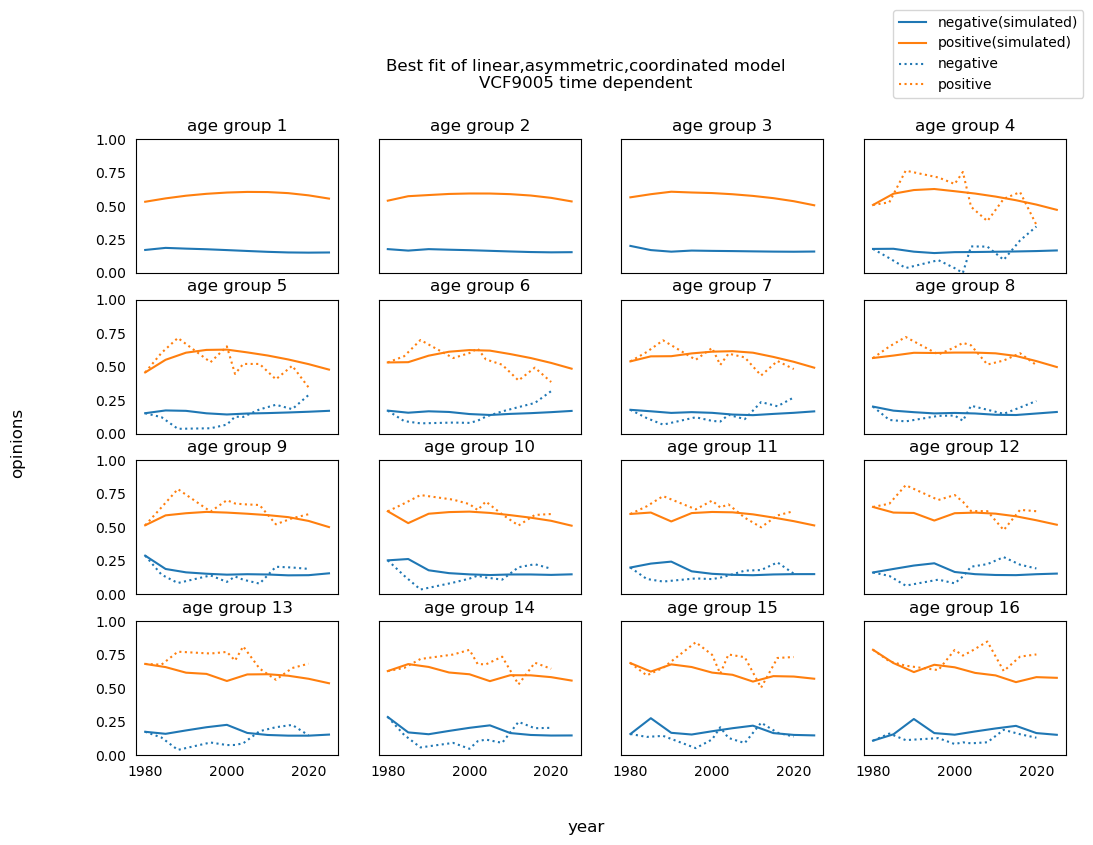

In [25]:
# Visualization
# find the optimal c and a, plot the comparison
BEL = (lacopt[0]+lacopt[1])*np.ones(tmax-1) + lacopt[2]*np.arange(0,tmax-1)
GAL = (lacopt[0]-lacopt[1])*np.ones(tmax-1) - lacopt[2]*np.arange(0,tmax-1)
BER = (lacopt[3]+lacopt[4])*np.ones(tmax-1) + lacopt[5]*np.arange(0,tmax-1)
GAR = (lacopt[3]-lacopt[4])*np.ones(tmax-1) - lacopt[5]*np.arange(0,tmax-1)
for k in range(tmax-1):
    for j in range(1, N):
        if BEL[k]*sum(W[j,:]) > 1 or BER[k]*sum(W[j, :])>1 or GAL[k]*sum(W[j,:]) > 1 or GAR[k]*sum(W[j, :])>1:
            print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,asymmetric,coordinated model\n'+varname+' time dependent')
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('therweightedtimefits/'+'lacfitW'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [26]:
# randomly choose ten initial guess
i = 0
nt = 1000
paramrec = np.zeros((8,nt))
costrec = np.zeros(nt)
costrec[0] = sselac
while i < nt:
    init = np.zeros(8)
    if i == 0:
        init[0] = lacopt[0] + lacopt[1]
        init[1] = lacopt[0] - lacopt[1]
        init[2] = lacopt[3] + lacopt[4]
        init[3] = lacopt[3] - lacopt[4]
        init[4], init[5] = lacopt[2], -lacopt[2]
        init[6], init[7] = lacopt[5], -lacopt[5]
    elif i == 1:
        init[0], init[2] = lsuopt[0], lsuopt[0]
        init[1], init[3] = lsuopt[1], lsuopt[1]
        init[4], init[6] = lsuopt[2], lsuopt[2]
        init[5], init[7] = lsuopt[3], lsuopt[3]
        costrec[1] = sselsu
    else:
        init[0], init[1], init[2], init[3] = random.uniform(0,0.1), random.uniform(0,0.1), random.uniform(0,0.1), random.uniform(0,0.1)
        init[4], init[5], init[6], init[7] = random.uniform(-0.001,0.001), random.uniform(-0.001,0.001), random.uniform(-0.001,0.001), random.uniform(-0.001,0.001)
    belinit = init[0]*np.ones(tmax-1) + init[4]*np.arange(0,tmax-1)
    galinit = init[1]*np.ones(tmax-1) + init[5]*np.arange(0,tmax-1)
    berinit = init[2]*np.ones(tmax-1) + init[6]*np.arange(0,tmax-1)
    garinit = init[3]*np.ones(tmax-1) + init[7]*np.arange(0,tmax-1)
    safe = True
    for k in range(tmax-1):
        for j in range(1, N):
            if belinit[k]*sum(W[j,:]) > 1 or berinit[k]*sum(W[j,:]) > 1 or galinit[k]*sum(W[j,:]) > 1 or garinit[k]*sum(W[j,:]) > 1:
                safe = False
    if safe and min(belinit) >= 0 and max(belinit) <= 1 and min(galinit) >= 0 and max(galinit) <= 1 and min(berinit) >= 0 and max(berinit) <= 1 and min(garinit) >= 0 and max(garinit) <= 1:
        if i < nt:
            paramrec[:,i] = init
            costrec[i] = Jlau(init)
        else:
            paramrec = np.append(paramrec, init.reshape(8, 1), axis = 1)
            costrec = np.append(Jlau(init))
        params, costs = grad_descent(Jlau,init,'lau')
        if len(params) == 0:
            i += 1
            continue
        lauopt = params[-1]
        BEL = lauopt[0]*np.ones(tmax-1) + lauopt[4]*np.arange(0,tmax-1)
        GAL = lauopt[1]*np.ones(tmax-1) + lauopt[5]*np.arange(0,tmax-1)
        BER = lauopt[2]*np.ones(tmax-1) + lauopt[6]*np.arange(0,tmax-1)
        GAR = lauopt[3]*np.ones(tmax-1) + lauopt[7]*np.arange(0,tmax-1)
        safe = True
        for k in range(tmax-1):
            for j in range(1, N):
                if BEL[k]*sum(W[j,:]) > 1 or BER[k]*sum(W[j, :])>1 or GAL[k]*sum(W[j,:]) > 1 or GAR[k]*sum(W[j, :])>1:
                    safe = False
                    break
        if len(costs) >= 1 and min(costs) > 0 and safe:
            if i < nt:
                paramrec[:,i] = params[-1]
                costrec[i] = costs[-1]
            else:
                paramrec = np.append(paramrec, params[-1].reshape(8, 1), axis = 1)
                costrec = np.append(costrec, costs[-1])
            if i % 100 == 0:
                print(i, min(costrec[:i+1]))
            i += 1
        elif i == 0 or i == 1:
            print(i, costrec[0])
            i += 1
    elif i == 0 or i == 1:
        i += 1

sselau = min(costrec)
besti = np.argmin(costrec)
lauopt = paramrec[:,besti]
print('minimum SSE:',round(sselau,5))
print('parameters:',np.around(lauopt,decimals=5))

0 2.095586352364632
100 2.095586352364632
200 2.095586352364632
300 2.095586352364632
400 2.095586352364632
500 2.095586352364632
600 2.095586352364632
700 2.095586352364632
800 2.095586352364632
900 2.095586352364632
minimum SSE: 2.09559
parameters: [ 0.01221  0.02318  0.03511  0.01162 -0.00134  0.00085 -0.00172  0.00168]


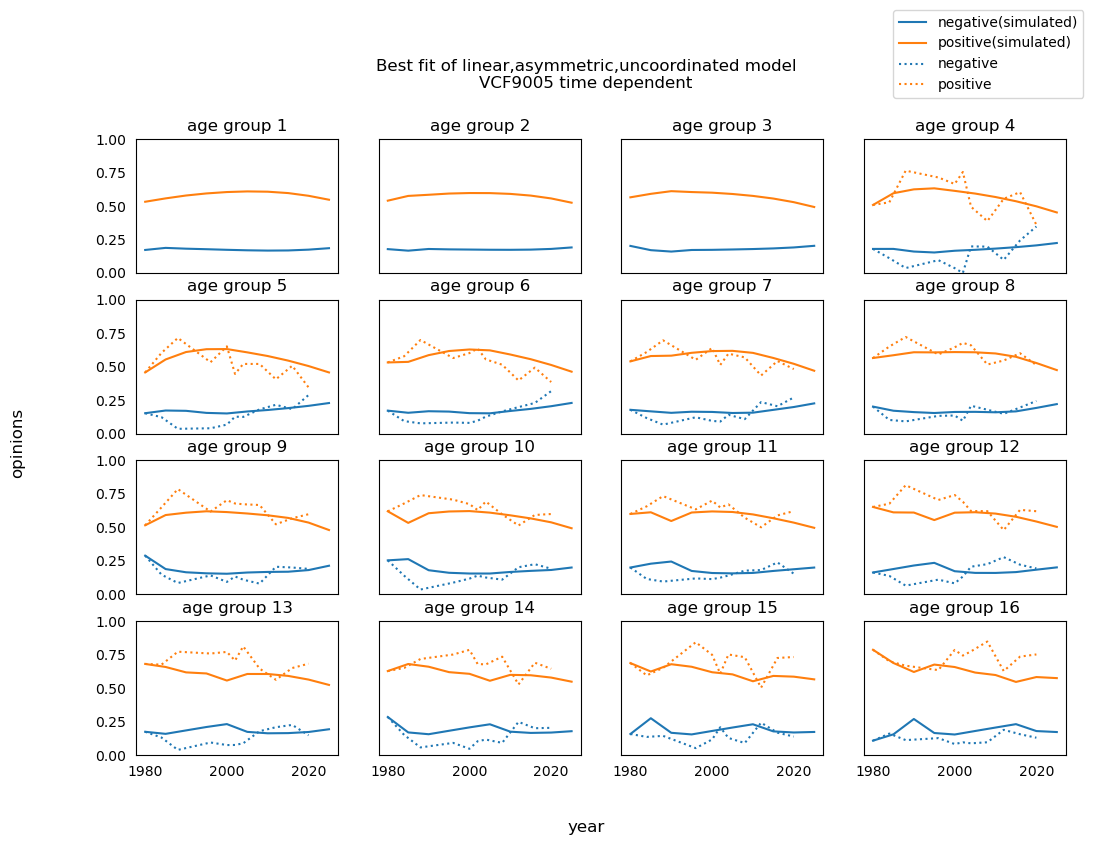

In [27]:
# Visualization
# find the optimal c and a, plot the comparison
BEL = lauopt[0]*np.ones(tmax-1) + lauopt[4]*np.arange(0,tmax-1)
GAL = lauopt[1]*np.ones(tmax-1) + lauopt[5]*np.arange(0,tmax-1)
BER = lauopt[2]*np.ones(tmax-1) + lauopt[6]*np.arange(0,tmax-1)
GAR = lauopt[3]*np.ones(tmax-1) + lauopt[7]*np.arange(0,tmax-1)
for k in range(tmax-1):
    for j in range(1, N):
        if BEL[k]*sum(W[j,:]) > 1 or BER[k]*sum(W[j, :])>1 or GAL[k]*sum(W[j,:]) > 1 or GAR[k]*sum(W[j, :])>1:
            print('Warning')
pneg,pneu,ppos = simasym(BEL,BER,GAL,GAR)

# stack plot for the real data
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (12,8))
for k in range(16):
    [i,j] = np.unravel_index(k,[4,4])
    #axs[i,j].stackplot(taxis,np.vstack([pneg[k,:],pneu[k,:],ppos[k,:]]))
    axs[i,j].plot(taxis,pneg[k,:],label='negative(simulated)')
    axs[i,j].plot(taxis,ppos[k,:],label='positive(simulated)')
    if k in range(3,16):
        kindex = ~np.isnan(In[:,4,k-3])
        axs[i,j].plot(t[kindex],In[kindex,4,k-3],color='tab:blue',linestyle=':',label='negative')
        axs[i,j].plot(t[kindex],In[kindex,6,k-3],color='tab:orange',linestyle=':',label='positive')             
    axs[i,j].tick_params(left = False, bottom = False)
    axs[i,j].set_title('age group '+str(k+1))
    axs[i,j].set_ylim(0,1)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
handles, labels = axs[3,3].get_legend_handles_labels()
lgd = fig.legend(handles,labels,loc="upper left", bbox_to_anchor=(0.75,1.05))
fig.suptitle('Best fit of linear,asymmetric,uncoordinated model\n' + varname + ' time dependent')
fig.supxlabel('year')
fig.supylabel('opinions')
plt.savefig('therweightedtimefits/'+'laufitW'+varname+'.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

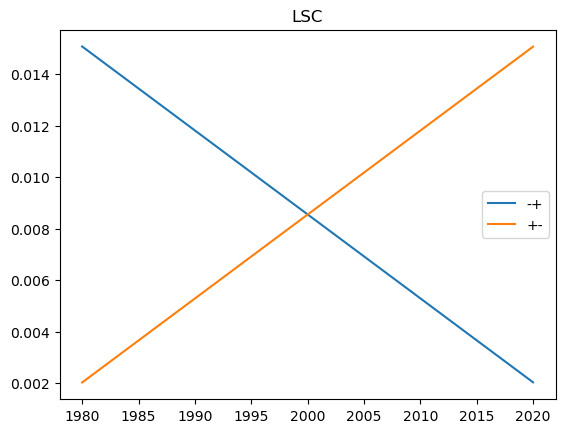

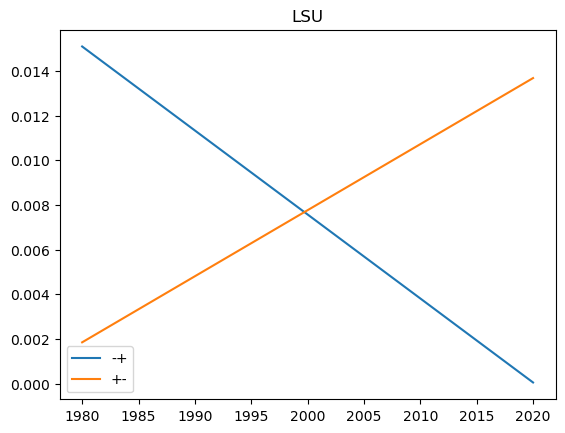

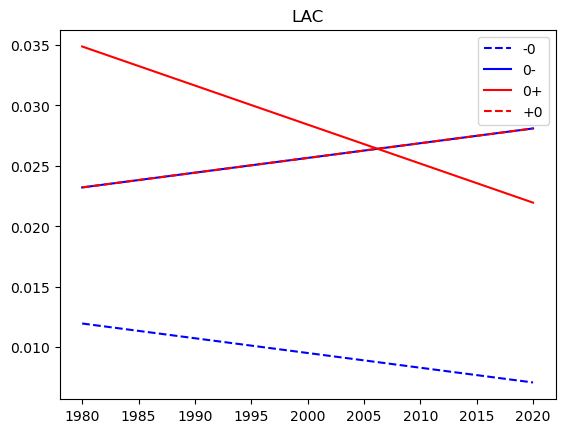

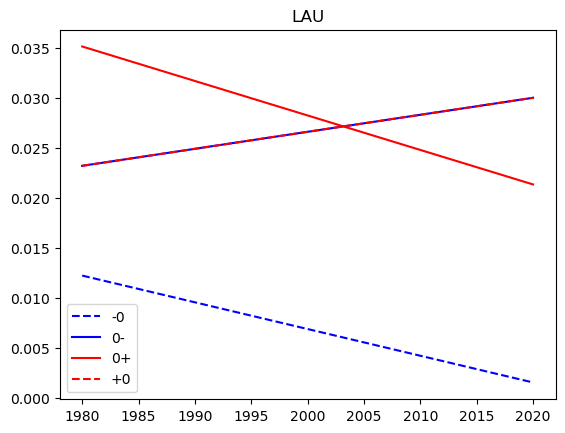

In [28]:
# plot coefficients
# lsc
be = (lscopt[0]+lscopt[1])*np.ones(tmax-1) + lscopt[2]*np.arange(0,tmax-1)
ga = (lscopt[0]-lscopt[1])*np.ones(tmax-1) - lscopt[2]*np.arange(0,tmax-1)
plt.plot(taxis[:-1], be, label = '-+')
plt.plot(taxis[:-1], ga, label = '+-')
plt.legend()
plt.title('LSC')
plt.show()
# lsu
be = lsuopt[0]*np.ones(tmax-1) + lsuopt[2]*np.arange(0,tmax-1)
ga = lsuopt[1]*np.ones(tmax-1) + lsuopt[3]*np.arange(0,tmax-1)
plt.plot(taxis[:-1], be, label = '-+')
plt.plot(taxis[:-1], ga, label = '+-')
plt.legend()
plt.title('LSU')
plt.show()
# lac
BEL = (lacopt[0]+lacopt[1])*np.ones(tmax-1) + lacopt[2]*np.arange(0,tmax-1)
GAL = (lacopt[0]-lacopt[1])*np.ones(tmax-1) - lacopt[2]*np.arange(0,tmax-1)
BER = (lacopt[3]+lacopt[4])*np.ones(tmax-1) + lacopt[5]*np.arange(0,tmax-1)
GAR = (lacopt[3]-lacopt[4])*np.ones(tmax-1) - lacopt[5]*np.arange(0,tmax-1)
plt.plot(taxis[:-1], BEL, 'b--', label = '-0')
plt.plot(taxis[:-1], GAL, 'b-', label = '0-')
plt.plot(taxis[:-1], BER, 'r-', label = '0+')
plt.plot(taxis[:-1], GAL, 'r--', label = '+0')
plt.legend()
plt.title('LAC')
plt.show()
# lau
BEL = lauopt[0]*np.ones(tmax-1) + lauopt[4]*np.arange(0,tmax-1)
GAL = lauopt[1]*np.ones(tmax-1) + lauopt[5]*np.arange(0,tmax-1)
BER = lauopt[2]*np.ones(tmax-1) + lauopt[6]*np.arange(0,tmax-1)
GAR = lauopt[3]*np.ones(tmax-1) + lauopt[7]*np.arange(0,tmax-1)
plt.plot(taxis[:-1], BEL, 'b--', label = '-0')
plt.plot(taxis[:-1], GAL, 'b-', label = '0-')
plt.plot(taxis[:-1], BER, 'r-', label = '0+')
plt.plot(taxis[:-1], GAL, 'r--', label = '+0')
plt.legend()
plt.title('LAU')
plt.show()

In [29]:
def AIC(k, N, SSE):
    return 2*k + N * math.log(SSE/N)

In [30]:
# number of data points
ndp = np.count_nonzero(~np.isnan(In[:,4,:]))
print(ndp)
aiccs = AIC(2, ndp, ssecs)
aiccas = AIC(4, ndp, ssecas)
aiclsc = AIC(3, ndp, sselsc)
aiclsu = AIC(4, ndp, sselsu)
aiclac = AIC(6, ndp, sselac)
aiclau = AIC(8, ndp, sselau)
print('AIC score of constant, symmetric model: ', round(aiccs,5))
print('AIC score of constant, asymmetric model: ', round(aiccas,5))
print('AIC score of linear, symmetric, coordinated model: ', round(aiclsc,5))
print('AIC score of linear, symmetric, uncoordinated model: ', round(aiclsu,5))
print('AIC score of linear, asymmetric, coordinated model: ', round(aiclac,5))
print('AIC score of linear, asymmetric, uncoordinated model: ', round(aiclau,5))
print('Best model is model', np.argmin([aiccs, aiccas, aiclsc, aiclsu, aiclac, aiclau])+1)

143
AIC score of constant, symmetric model:  -557.65923
AIC score of constant, asymmetric model:  -556.40138
AIC score of linear, symmetric, coordinated model:  -579.05633
AIC score of linear, symmetric, uncoordinated model:  -580.77993
AIC score of linear, asymmetric, coordinated model:  -584.54945
AIC score of linear, asymmetric, uncoordinated model:  -587.89061
Best model is model 6


In [31]:
print('number of data points: ', ndp)

print('LSC model: ', round(sselsc,5), '\n', np.around(lscopt,decimals=5))
print('LSU model: ', round(sselsu,5), '\n', np.around(lsuopt,decimals=5))
print('LAC model: ', round(sselac,5), '\n', np.around(lacopt,decimals=5))
print('LAU model: ', round(sselau,5), '\n', np.around(lauopt,decimals=5))

number of data points:  143
LSC model:  2.39059 
 [ 0.00855  0.00652 -0.00163]
LSU model:  2.32915 
 [ 0.01509  0.00185 -0.00188  0.00148]
LAC model:  2.20598 
 [ 0.0176  -0.00563 -0.00061  0.02349  0.01139 -0.00161]
LAU model:  2.09559 
 [ 0.01221  0.02318  0.03511  0.01162 -0.00134  0.00085 -0.00172  0.00168]
